In [4]:
import matplotlib.pyplot as plt
from matplotlib import animation
import random
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from pyod.models.knn import KNN

%matplotlib inline

In [5]:
#load data
DroneData = pd.read_csv('./DroneData/SP Cup 2020/IMU_camera Drone Synchronized training dataset_normal behabiour_no abnormalities/_slash_mavros_slash_imu_slash_data.csv')


In [6]:
def extract_normalization_params(DroneData, params = ['x','y','z','x.1','y.1','z.1','x.2','y.2','z.2']):
    """
    Extracts only the normal distribution z scores 
    of from the data
    input = Data, parameters
    """
    imuParamsData = DroneData.loc[:, params]
    normImuData = (imuParamsData - imuParamsData.mean())/imuParamsData.std()
    return normImuData, imuParamsData.mean(), imuParamsData.std()

def normalize_test_data(Data, mean, std, params = ['x','y','z','x.1','y.1','z.1','x.2','y.2','z.2']):
    imuParamsData = Data.loc[:, params]
    normImuData = (imuParamsData - mean)/std
    return normImuData

def find_theta_score(Data,dims=1):
    """
    Converts n dimensions to a lower dimensional score,
    for easier visualization
    """
    pca = PCA(n_components=dims)
    pca.fit(Data)
    theta_score = pca.transform(Data)
    return theta_score

def plot_anomalies_in_1D(z_score, anomalyPrediction):
    """
    plots anomalies (red) and 1D z score of the dataset
    """
    for i in range(len(z_score)):
        if anomalyPrediction[i] == True:
            plt.scatter(i,z_score[i],c = 'r')
    plt.plot(z_score)

def plot_anomalies_in_2D(z2_score, anomalyPrediction):
    """
    plots z1 and z2 as a scatter plot on x and y axes respectively,
    with anomalies as red points and normal instances as blue
    """
    for i in range(len(z2_score.T)):
        if anomalyPrediction[i]:
            plt.scatter(z2_score[0][i],z2_score[1][i],c = 'r')
        else:
            plt.scatter(z2_score[0][i],z2_score[1][i],c = 'b')
            
def generate_metrics(anomalyPrediction,testDataLabel):
    """
    generates accuracy and detection rate metrics, takes
    into input the prediction and the label column of the data
    lengths of the two vectors must match
    """
    actual_value = testDataLabel == 4
    #how many readings match
    N_set = anomalyPrediction == actual_value
    
    accuracy = sum(N_set)/len(testDataLabel)
    detection_rate = sum(anomalyPrediction)/sum(actual_value)
    false_positives = sum(np.logical_and((np.invert(actual_value)), anomalyPrediction))/len(testDataLabel)
    false_negatives = sum(np.logical_and(actual_value, np.invert(anomalyPrediction)))/len(testDataLabel)
    print('accuracy = ', accuracy,',detection rate =', detection_rate,'\nfalse positive rate = '
          ,false_positives,',false negative rate =',false_negatives)

In [7]:
#fit mean and std for normalization

normImuData, mean , std = extract_normalization_params(DroneData)
trainData = normImuData

In [8]:
#import new test data here
testData1 = normalize_test_data(pd.concat([pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-32-12/_slash_mavros_slash_imu_slash_data.csv'),
                                         pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-32-49/_slash_mavros_slash_imu_slash_data.csv'),
                                          pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-33-26/_slash_mavros_slash_imu_slash_data.csv'),
                                          pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-34-08/_slash_mavros_slash_imu_slash_data.csv'),
                                          pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-34-43/_slash_mavros_slash_imu_slash_data.csv')]), mean, std)

testData2 = normalize_test_data(pd.read_csv('DroneData/SP Cup 2020/04_Dataset with 5 abnormal experiments_17Jan2020/2020-01-17-11-37-25/_slash_mavros_slash_imu_slash_data.csv'), mean, std)
z_score1 = find_theta_score(testData1)
z_score2 = find_theta_score(testData2)

/home/pratik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/pratik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/pratik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


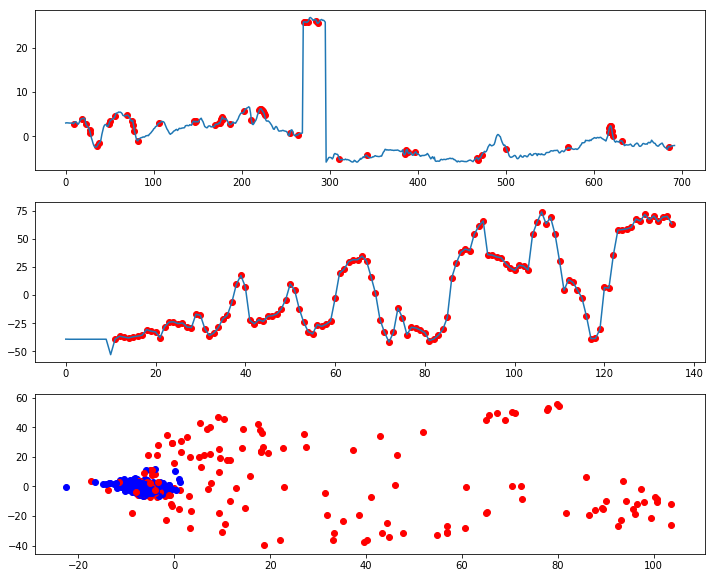

In [9]:
# using IsoFo

#add your algos in this very format pls

from sklearn.ensemble import IsolationForest

#fit isofo model
clf = IsolationForest(n_estimators=1000,contamination=0.0000) #contamination parameter specifies the level of contamination in training data
clf.fit(trainData)

#predict anomalies
tempanomalyPrediction1 = clf.predict(testData1)
anomalyPrediction1 = tempanomalyPrediction1 == -1

#isofo is statistical, so we need to specify contamination beforehand, 
#which may not be a good method since our problem is very sparse in nature
plt.figure(figsize = (12,10))
plt.subplot(3,1,1)
plot_anomalies_in_1D(z_score1, anomalyPrediction1)

tempanomalyPrediction2 = clf.predict(testData2)
anomalyPrediction2 = tempanomalyPrediction2 == -1
plt.subplot(3,1,2)
plot_anomalies_in_1D(z_score2, anomalyPrediction2)

z2_score = find_theta_score(pd.concat([testData1, testData2],ignore_index = True),2)
plt.subplot(3,1,3)
plot_anomalies_in_2D(z2_score.T, np.concatenate([anomalyPrediction1, anomalyPrediction2]))

In [17]:
#left blank intentionally

In [20]:
#using one class SVM

from sklearn.svm import OneClassSVM

#fit model
oneclass = OneClassSVM(kernel='linear', nu=0.971)
oneclass.fit(trainData)

#predict anomalies
tempanomalyPredictionSVM1 = oneclass.predict(testData1)
anomalyPredictionSVM1 = tempanomalyPredictionSVM1 == 1

#isofo is statistical, so we need to specify contamination beforehand, 
#which may not be a good method since our problem is very sparse in nature
plt.figure(figsize = (12,10))
plt.subplot(3,1,1)
plot_anomalies_in_1D(z_score1, anomalyPredictionSVM1)

tempanomalyPredictionSVM2 = oneclass.predict(testData2)
anomalyPredictionSVM2 = tempanomalyPredictionSVM2 == 1
plt.subplot(3,1,2)
plot_anomalies_in_1D(z_score2, anomalyPredictionSVM2)
plt.subplot(3,1,3)
plot_anomalies_in_2D(z2_score.T, np.concatenate([anomalyPrediction1, anomalyPrediction2]))

In [22]:
#using KNN
from pyod.models.knn import KNN

params = ['x','y','z','x.1','y.1','z.1','x.2','y.2','z.2']
#fit model
lof = KNN()

z = find_theta_score(trainData ,2)

lof.fit(z)
scores = lof.decision_scores_
test_scores1 = lof.decision_function(find_theta_score(testData1,2))
test_scores2 = lof.decision_function(find_theta_score(testData2,2))

thres = scores.mean()+13.929*scores.std()
anomalyPredictionLOF = test_scores1 > thres
anomalyPredictionLOF1 = test_scores2 > thres
plt.figure(figsize = (12,10))
plt.subplot(3,1,1)
plot_anomalies_in_1D(z_score1, anomalyPredictionLOF)
plt.subplot(3,1,2)
plot_anomalies_in_1D(z_score2, anomalyPredictionLOF1)
plt.subplot(3,1,3)
plot_anomalies_in_2D(z2_score.T, np.concatenate([anomalyPredictionLOF,anomalyPredictionLOF1]))


# IMAGE DATA TESTING HAS BEEN MIGRATED TO TestingImage.ipynb